In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.7 MB/s 


In [ ]:
import tensorflow as tf # 2.3
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist
import time as time

Import les donées 导入数据

In [ ]:
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()
# train_image.shape = (60000, 28, 28), train_labels.shape = (60000,)

11490434/11490434 [==============================] - 0s 0us/step


Traitement les données 数据处理

In [ ]:
# Normalisation les données 0 - 255 en -1 - 1
train_image = (train_image - 127.5)/127.5 # 把0-255的数据范围变为-1到1之间
test_image = (test_image - 127.5)/127.5 # 把0-255的数据范围变为-1到1之间

# Augmenter la dimension du canal 增加通道维度
#train_image = tf.expand_dims(train_image, -1)
#test_image = tf.expand_dims(test_image, -1)
# train_image.shape = ([60000, 28, 28, 1]), train_labels.shape = (60000,)

# Transformation de type 类型转换
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

Créer un jeu de données 创建数据集

In [ ]:
# 创建Dataset
batchsize = 128
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(60000).batch(batchsize)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(batchsize)

In [ ]:
print(test_labels[0])

tf.Tensor(7, shape=(), dtype=int64)


In [ ]:
for element in test_dataset:
  print(element[1])

#print(dataset[1])
#print(test_dataset.shape)

## Construire le modèle MLP maxout et l'entraîner 搭建MLP模型并训练

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_img(input_image, input_label, epsilon):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  adv_img = input_image + epsilon*signed_grad
  adv_img = tf.clip_by_value(adv_image, -1, 1)
  return signed_grad

In [ ]:
def max_out(inputs, num_units, axis=None):
    shape = inputs.get_shape().as_list()
    if shape[0] is None:
        shape[0] = -1
    if axis is None:  # Assume that channel is the last dimension
        axis = -1
    num_channels = shape[axis]
    if num_channels % num_units:
        raise ValueError('number of features({}) is not '
                         'a multiple of num_units({})'.format(num_channels, num_units))
    shape[axis] = num_units
    shape += [num_channels // num_units]
    outputs = tf.reduce_max(tf.reshape(inputs, shape), -1, keepdims=False)
    return outputs

In [66]:
# Build model
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1200)(x)
x = max_out(x, 300, axis=None)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(40)(x)
x = max_out(x, 10, axis=None)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dropout_4 (Dropout)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 1200)              942000    
                                                                 
 tf.reshape_4 (TFOpLambda)   (None, 300, 4)            0         
                                                                 
 tf.math.reduce_max_4 (TFOpL  (None, 300)              0         
 ambda)                                                          
                                                           

## train maxout network without FGSM

In [67]:
optimizer = tf.keras.optimizers.Adam(decay=1e-6)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
#optimizer = tf.optimizers.SGD(learning_rate)
model.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history = model.fit(dataset,validation_data=test_dataset,epochs=50) # 返回字典类型的数据 其中记录了准确率和损失的信息

Epoch 1/50
469/469 [==============================] - 11s 23ms/step - loss: 0.7256 - acc: 0.7721 - val_loss: 0.2512 - val_acc: 0.9283
Epoch 2/50
469/469 [==============================] - 11s 22ms/step - loss: 0.3621 - acc: 0.8881 - val_loss: 0.1807 - val_acc: 0.9446
Epoch 3/50
469/469 [==============================] - 11s 22ms/step - loss: 0.2886 - acc: 0.9104 - val_loss: 0.1488 - val_acc: 0.9538
Epoch 4/50
469/469 [==============================] - 11s 22ms/step - loss: 0.2522 - acc: 0.9209 - val_loss: 0.1354 - val_acc: 0.9601
Epoch 5/50
469/469 [==============================] - 11s 24ms/step - loss: 0.2299 - acc: 0.9283 - val_loss: 0.1131 - val_acc: 0.9643
Epoch 6/50
469/469 [==============================] - 13s 27ms/step - loss: 0.2108 - acc: 0.9334 - val_loss: 0.1051 - val_acc: 0.9672
Epoch 7/50
469/469 [==============================] - 11s 23ms/step - loss: 0.1962 - acc: 0.9380 - val_loss: 0.0986 - val_acc: 0.9695
Epoch 8/50
469/469 [==============================] - 14s 29ms

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def loss_with_FGSM(model,input_image, input_label, epsilon=1, alpha=0.5):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = model(input_image)
      loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
    signed_grad = tf.sign(gradient)
    adv_img = input_image + epsilon*signed_grad
    adv_img = tf.clip_by_value(adv_img, -1, 1)
    prediction2 = model(adv_img)
    loss2 = loss_object(input_label, prediction2)
    return alpha*loss + (1-alpha) * loss2

## Train with loss_with_FGSM (To check)

In [ ]:
def training_loop(model, epochs, optimizer, learning_rate, loss_fn, train_set, val_images, val_labels, nombre_example=60000, batchsize=128):
	average_time_step = []
	optimizer.lr = learning_rate
	acc_collect = []
	loss_collect = []
	len = int(np.floor(nombre_example / batchsize))
	total_steps = epochs*len
	for epoch in range(epochs):
		if epoch > 20:
			optimizer.lr = learning_rate/10
		if epoch > 40:
			optimizer.lr = learning_rate/100
		start_epoch = time.time()
		step = 0
		for element in dataset:
			step = step+1
			start_step = time.time()
			images  = element[0]
			labels =element[1] 
			with tf.GradientTape() as tape:
				loss_value = loss_with_FGSM(model, images, labels, epsilon=0.5, alpha=0.5)
			grads = tape.gradient(loss_value, model.trainable_weights)
			optimizer.apply_gradients(zip(grads, model.trainable_weights))
			if step == len-1:
				logits_val = model(val_images, training=True)
				logits_val = np.argmax(logits_val, axis=-1)
				m = tf.keras.metrics.Accuracy()
				m.update_state(val_labels, logits_val)
				acc_collect.append(m.result().numpy())
				print('epoch = ',epoch,'acc train fin epoch = ',m.result().numpy())
				loss_value_temp = loss_value._copy()
				loss_value_temp = float(loss_value_temp)
				loss_collect.append(loss_value_temp)
				print('loss fin epoch = ',loss_value_temp)
	print()
	return model

Accuracy value decreased after adding penalty. Computation time is significantly longer (Need correction)

In [ ]:
model = training_loop(model, epochs=10, optimizer=optimizer, learning_rate=0.001, loss_fn=loss_func, train_set=dataset, val_images=test_image, val_labels=test_labels, nombre_example=60000, batchsize=128)

epoch =  0 acc train fin epoch =  0.3135
loss fin epoch =  1.2127217054367065
epoch =  1 acc train fin epoch =  0.3618
loss fin epoch =  1.0525729656219482
epoch =  2 acc train fin epoch =  0.4091
loss fin epoch =  0.9534614086151123
epoch =  3 acc train fin epoch =  0.4504
loss fin epoch =  0.6421814560890198
epoch =  4 acc train fin epoch =  0.4886
loss fin epoch =  0.8858319520950317
epoch =  5 acc train fin epoch =  0.5205
loss fin epoch =  0.7137510776519775
epoch =  6 acc train fin epoch =  0.599
loss fin epoch =  0.7489454746246338
epoch =  7 acc train fin epoch =  0.6551
loss fin epoch =  0.5935859680175781
epoch =  8 acc train fin epoch =  0.6792
loss fin epoch =  0.8257623314857483
epoch =  9 acc train fin epoch =  0.727
loss fin epoch =  0.5658345222473145



##Implémenter FGSM(Fast Gradient Sign Method)
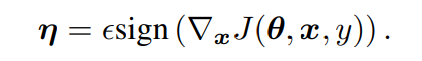

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
perturbations = create_adversarial_pattern(test_image, test_labels)

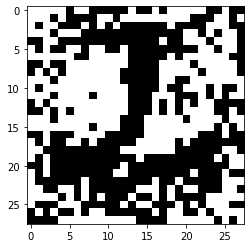

In [ ]:
#check la première perturbation 查看第一个扰动
plt.imshow(perturbations[0],cmap='gray_r')#image en niveaux de gris

Définir une fonction pour plot les images

In [ ]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette true par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, num = 10):
  fig = plt.figure(figsize=(2*num,3)) # figsize:指定figure的宽和高，单位为英寸
  for i in range(num):   # pre_image的shape的第一个维度就是个数，这里是num
      plt.subplot(1,num,i+1) # 几行几列的 第i+1个图片（从1开始）
      plt.imshow(image[i,:,:],cmap='gray') # + 1)/2) # 加1除2: 将生成的-1～1的图片弄到0-1之间,
      plt.title('{} -> {}'.format(label[i],adv_label[i]))
      plt.axis('off') # 不要坐标
  plt.show()


##Ajouter la perturbations et Tester dans le jeu de test

In [ ]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

## Train with adverseral example


In [ ]:
perturb = create_adversarial_pattern(train_image, train_labels)
train_adv = train_image+0.3*perturb
train_train_adv = tf.concat([train_image, train_adv], 0) #对抗训练集 = 原训练集+加了扰动的训练集 （120000 images） 
print(np.shape(train_train_adv))
labels_label_adv = tf.concat([train_labels, train_labels], 0)  #labels = 2*原labels，因为加了扰动的图像还属于该标签

(120000, 28, 28)


In [ ]:
dataset_adv = tf.data.Dataset.from_tensor_slices((train_train_adv, labels_label_adv)).shuffle(120000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

In [ ]:
# Build model
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1200)(x)
x = max_out(x, 300, axis=None)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(40)(x)
x = max_out(x, 10, axis=None)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model_adv = tf.keras.Model(inputs, outputs)
model_adv.summary()

In [ ]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  adv_image = test_image + eps*perturbations      # 对抗样本测试集=测试集加上干扰
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  #test_image = tf.clip_by_value(adv_image, -1, 1)
  predict_label = model.predict(adv_image) 
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_predict_label = model_adv.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score1 = model.evaluate(adv_image,test_labels,verbose=0)
  acc_list.append(score1[1])
  score = model_adv.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

  ## 输出标签：原模型对对抗样例的预测 -> 用对抗训练的模型对对抗样例的预测

Afficher la précision en fonction d'epsilons

In [ ]:
plt.figure()
plt.plot(epsilons,adv_acc_list,label='acc_model_adv')
plt.plot(epsilons,acc_list,label='acc_model')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',adv_acc_list)
print('epsilons',epsilons)

In [ ]:
# 